In [117]:
# Import necessary libraries
import sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from scipy import stats
import seaborn as sns

#load the dataset
california_housing = fetch_california_housing(as_frame=True)

df = california_housing.frame


# Step 1: Data standardization (excluding latitude and longitude)
scaler = StandardScaler()
columns_to_scale = df.columns.difference(['Latitude', 'Longitude', 'MedHouseVal'])
df_standard = df.copy()  # Make a copy of the original DataFrame
df_standard[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Add back Latitude and Longitude without scaling
df_standard[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']]
df_standard

# Step 2: Look for outliers using 2D visualization (for a couple of features)
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=df_standard)
# plt.show()

# Step 3: Look for outliers using 3D visualization (for three features)

fig = px.scatter_3d(
    df_standard,
    x='MedInc',
    y='AveRooms',
    z='Population',
    color='MedHouseVal'
)

# fig.show()

# Step 4: Remove outliers
# We will use Z-score to identify and remove outliers
df_clean = df_standard[(np.abs(stats.zscore(df_standard)) < 3).all(axis=1)]

# df_clean

# Step 5: Check for missing values
missing_values = df_clean.isnull().sum()
# Print the missing values (if any)

# print(missing_values)

# Step 6: Handle missing values (if any)
# For this dataset, there are no missing values usually, but if there were, you could handle them like this:
df_clean = df_clean.fillna(df_clean.mean()) # to replace with mean
df_clean.dropna(inplace=True) # to remove rows with missing values

# Step 7: Check for any categorical values
# This dataset does not contain categorical features

# Step 8: Perform dimensionality reduction
# Keep 95% of variance
pca = PCA(n_components=0.95)
df_reduced = pca.fit_transform(df_clean)
# print("Reduced dataset shape:", df_reduced.shape)
# pca.explained_variance_ratio_

df_clean['dimensionality_reduced'] = list(df_reduced)
# df_clean


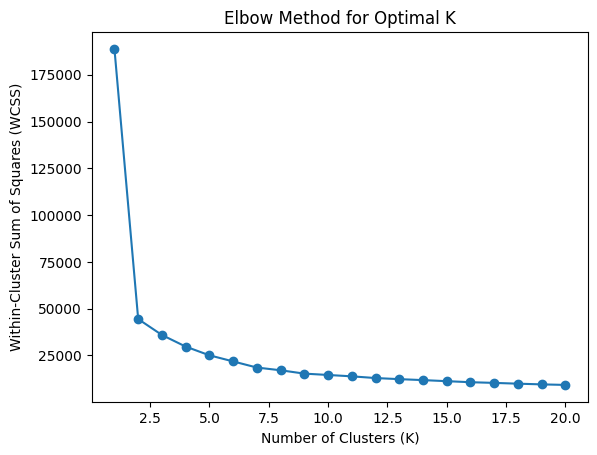

In [118]:
from sklearn.cluster import KMeans

# Select features for clustering
features = ["MedInc", "AveRooms", "Latitude", "Longitude"]

# Extract selected features from DataFrame
X = df_clean[features]

# Initialize list to store WCSS values
wcss = []

# Range of K values to try
k_values = range(1, 21)  # You can adjust the range as needed

# Calculate WCSS for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot WCSS against number of clusters (K)
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

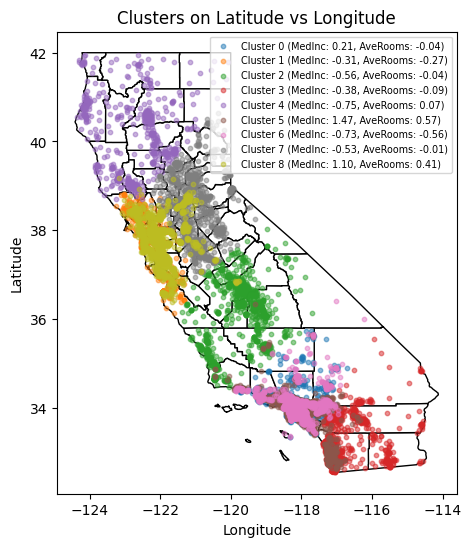

In [165]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the shapefile of California counties
california_counties = gpd.read_file("shapefile/ne_10m_admin_2_counties.shp")
california_counties = california_counties[california_counties['REGION'] == 'CA']

# Select features for clustering
features = ["MedInc", "AveRooms", "Latitude", "Longitude"]

# Extract selected features from DataFrame
X = df_clean[features]

# Choose the number of clusters (K)
k = 9

# Fit K-means model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Add cluster labels to DataFrame
df_clean['Cluster'] = kmeans.labels_

# Calculate average values for MedInc and AveRooms for each cluster
cluster_avg_values = df_clean.groupby('Cluster')[['MedInc', 'AveRooms']].mean()

# Plot California counties with cluster points overlay
fig, ax = plt.subplots(figsize=(10, 6))

california_counties.plot(ax=ax, color='white', edgecolor='black')

for cluster in range(k):
    cluster_data = df_clean[df_clean['Cluster'] == cluster]
    ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'], label=f'Cluster {cluster} (MedInc: {cluster_avg_values.loc[cluster, "MedInc"]:.2f}, AveRooms: {cluster_avg_values.loc[cluster, "AveRooms"]:.2f})', alpha=0.5, s=10)  # Include average values in the label

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clusters on Latitude vs Longitude')
ax.legend(fontsize='x-small')

# Show plot
plt.show()

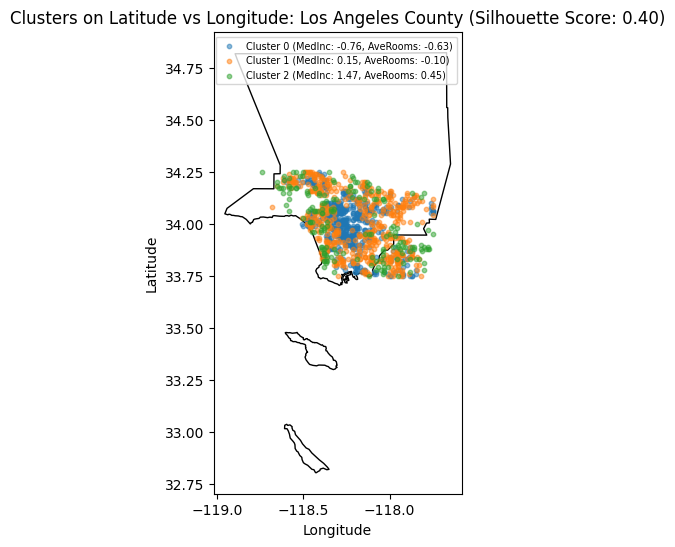

In [184]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Load the shapefile of California counties
california_counties = gpd.read_file("shapefile/ne_10m_admin_2_counties.shp")
california_counties = california_counties[california_counties['REGION'] == 'CA']
california_counties = california_counties[california_counties['NAME'].isin(['Los Angeles'])]

# Define latitude and longitude ranges for the regions of interest
la_latitude_range = (33.75, 34.25)
la_longitude_range = (-118.75, -117.75)

# Filter the DataFrame to include only data points within the specified latitude and longitude ranges
la_data = df_clean[(df_clean['Latitude'] >= la_latitude_range[0]) & (df_clean['Latitude'] <= la_latitude_range[1]) &
                   (df_clean['Longitude'] >= la_longitude_range[0]) & (df_clean['Longitude'] <= la_longitude_range[1])]

# Select features for clustering
features = ["MedInc", "AveRooms", "Latitude", "Longitude"]

# Extract selected features from the filtered DataFrame
X = la_data[features]

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Choose the number of clusters (K)
k = 3

# Fit K-means model on the training data
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

# Predict clusters for the testing data
labels = kmeans.predict(X_test)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_test, labels)

# Add cluster labels to the testing DataFrame
X_test['Cluster'] = labels

# Calculate average values for MedInc and AveRooms for each cluster in the testing data
cluster_avg_values = X_test.groupby('Cluster')[['MedInc', 'AveRooms']].mean()

# Plot California counties with cluster points overlay for Los Angeles County
fig, ax = plt.subplots(figsize=(10, 6))

california_counties.plot(ax=ax, color='white', edgecolor='black')

for cluster in range(k):
    cluster_data = X_test[X_test['Cluster'] == cluster]
    ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'], label=f'Cluster {cluster} (MedInc: {cluster_avg_values.loc[cluster, "MedInc"]:.2f}, AveRooms: {cluster_avg_values.loc[cluster, "AveRooms"]:.2f})', alpha=0.5, s=10)  # Include average values in the label

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Clusters on Latitude vs Longitude: Los Angeles County (Silhouette Score: {silhouette_avg:.2f})')
ax.legend(fontsize='x-small')

# Show plot
plt.show()


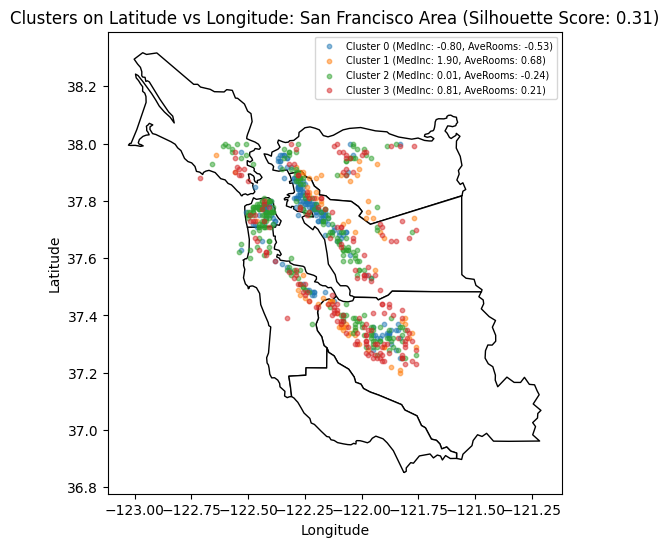

In [186]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Load the shapefile of California counties
california_counties = gpd.read_file("shapefile/ne_10m_admin_2_counties.shp")
california_counties = california_counties[california_counties['REGION'] == 'CA']
california_counties = california_counties[california_counties['NAME'].isin(['San Francisco', 'San Mateo', 'Santa Clara', 'Santa Cruz','Alameda', 'Marin', 'Contra Costa'])]

# Define latitude and longitude ranges for the regions of interest
la_latitude_range = (37.2, 38)
la_longitude_range = (-123, -121.75)

# Filter the DataFrame to include only data points within the specified latitude and longitude ranges
la_data = df_clean[(df_clean['Latitude'] >= la_latitude_range[0]) & (df_clean['Latitude'] <= la_latitude_range[1]) &
                   (df_clean['Longitude'] >= la_longitude_range[0]) & (df_clean['Longitude'] <= la_longitude_range[1])]

# Select features for clustering
features = ["MedInc", "AveRooms", "Latitude", "Longitude"]

# Extract selected features from the filtered DataFrame
X = la_data[features]

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Choose the number of clusters (K)
k = 4

# Fit K-means model on the training data
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

# Predict clusters for the testing data
labels = kmeans.predict(X_test)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_test, labels)

# Add cluster labels to the testing DataFrame
X_test['Cluster'] = labels

# Calculate average values for MedInc and AveRooms for each cluster in the testing data
cluster_avg_values = X_test.groupby('Cluster')[['MedInc', 'AveRooms']].mean()

fig, ax = plt.subplots(figsize=(10, 6))

california_counties.plot(ax=ax, color='white', edgecolor='black')

for cluster in range(k):
    cluster_data = X_test[X_test['Cluster'] == cluster]
    ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'], label=f'Cluster {cluster} (MedInc: {cluster_avg_values.loc[cluster, "MedInc"]:.2f}, AveRooms: {cluster_avg_values.loc[cluster, "AveRooms"]:.2f})', alpha=0.5, s=10)  # Include average values in the label

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Clusters on Latitude vs Longitude: San Francisco Area (Silhouette Score: {silhouette_avg:.2f})')
ax.legend(fontsize='x-small')

# Show plot
plt.show()